In [14]:
from __future__ import division, print_function

In [15]:
%load_ext autoreload
%autoreload 2
%pylab inline
# %pylab notebook
# %load_ext wurlitzer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [16]:
# standard imports
import time
import numpy as np
from collections import namedtuple
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# drake + externals imports
from director import viewerclient as vc
from irispy import Polyhedron
import pydrake.solvers.mathematicalprogram as mathematicalprogram

# boxatlas
import boxatlas.boxatlas as box
from boxatlas.contactstabilization import BoxAtlasContactStabilization
from utils.polynomial import Polynomial
from utils.piecewise import Piecewise
from boxatlas.contactstabilizationutils import ContactStabilizationUtils as CSU


In [17]:
vis = vc.Visualizer()

In [18]:
def makeEnvironment(dist_to_wall=None, mu_wall=0.25, mu_floor = 0.5):
    if dist_to_wall is None:
        dist_to_wall = dict()
        dist_to_wall['left'] = -0.5
        dist_to_wall['right'] = 0.5

    # construct the different wall surfaces, note that one needs to be careful with the 
    # friction cones, they are all in world frame at the moment, should probably fix this
    right_wall_surface = box.Surface(Polyhedron.fromBounds([dist_to_wall['right'], 0], [dist_to_wall['right'], 2]),
                Polyhedron(np.array([[mu_wall, -1], [mu_wall, 1]]), np.array([0, 0])))

    left_wall_surface = box.Surface(Polyhedron.fromBounds([dist_to_wall['left'], 0], [dist_to_wall['left'], 2]),
                Polyhedron(np.array([[-mu_wall, -1], [-mu_wall, 1]]), np.array([0, 0])))

    floor_surface = box.Surface(Polyhedron.fromBounds([dist_to_wall["left"], 0], [dist_to_wall["right"], 0]), 
                Polyhedron(np.array([[-1, -mu_floor], [1, -mu_floor]]), np.array([0, 0])))

    surfaces = [None]*4
    surfaces[0] = right_wall_surface
    surfaces[1] = floor_surface
    surfaces[2] = floor_surface
    surfaces[3] = left_wall_surface

    env = box.Environment(surfaces, Polyhedron.fromBounds([dist_to_wall['left'], 0], [dist_to_wall['right'], 2]))
    return env

default_env = makeEnvironment()

limb_idx_map = dict()
limb_idx_map["right_arm"] = 0
limb_idx_map["right_leg"] = 1
limb_idx_map["left_leg"] = 2
limb_idx_map["left_arm"] = 3


atlas = box.BoxAtlas()
# atlas.limb_velocity_limits = limb_velocity_limits

# relax kinematic constraints on the legs
large_leg_limb_bound = Polyhedron.fromBounds([-2.0, -1.0], [2.0, -0.5])
leg_names = ["left_leg", "right_leg"]
for limb in leg_names:
    idx = limb_idx_map[limb]
    atlas.limb_bounds[idx] = large_leg_limb_bound
    

params_nom = BoxAtlasContactStabilization.get_optimization_parameters()
params_nom['costs']['contact_force'] = 1e-3
params_nom['costs']['qcom_running'] = 1
params_nom['costs']['vcom_running'] = 1
params_nom['costs']['limb_running'] = 1
params_nom['costs']['qcom_final'] = 1e3
params_nom['costs']['vcom_final'] = 1e4
params_nom['costs']['arm_final_position'] = 1e1
params_nom['costs']['limb_velocity'] = 1e-1
params_nom['costs']['leg_final_position'] = 1e2




def add_persistent_contact_constraints(opt, contact_name):
    """
    :param opt  BoxAtlasContactStabilization
    """
    idx = opt.robot.limb_idx_map[contact_name]
    contact = opt.vars.contact[idx]
    
    for var in contact.at_all_breaks():
        opt.prog.AddLinearConstraint(var[0] == 1)
        
def make_contact_assignment(dt, num_time_steps, constrained_limbs=None):
    """
    @inputs
    constrained_limbs: should be a dict with limb_name and value to which it is constrained
    
    default:
        both feet to always be in contact,
        right hand never to be in contact.
    """
    
    if constrained_limbs is None:
        constrained_limbs = dict()
        constrained_limbs["right_leg"] = 1 # persistent contact
        constrained_limbs["left_leg"] = 1 # persistent contact
        constrained_limbs["right_arm"] = 0 # not in contact
    
    
    time_horizon = num_time_steps * dt
    ts = np.linspace(0, time_horizon, time_horizon / dt + 1)
    domain = ts
    
    contact_assignments = [None]*len(limb_idx_map)
    
    for limb_name, val in constrained_limbs.iteritems():
        limb_idx = limb_idx_map[limb_name]
        contact_assignments[limb_idx] = Piecewise(domain,
                         [Polynomial(np.array([[val]]))
                              for j in range(len(domain) - 1)]) 
    return contact_assignments
        
def add_feet_always_in_contact_constraints(opt):
    contact_names = ["left_leg", "right_leg"]
    for contact_name in contact_names:
        add_persistent_contact_constraints(opt, contact_name)


def solveContactStabilization(opt=None, initial_state=None, params=None, **kwargs):
    start_time = time.time()
    if opt is None:
        if initial_state is None:
            initial_state = makeDefaultInitialState()         
        
        desired_state = makeDefaultDesiredState()
        opt = BoxAtlasContactStabilization(initial_state, default_env, desired_state,
                                           params=params,
                                          **kwargs)
    
    solve_start_time = time.time()
    solnData = opt.solve()
    elapsed_in_ms = 1e3*(time.time() - solve_start_time)
    print("solution took " + str(elapsed_in_ms) + " ms")
    
    elapsed_in_ms = 1e3*(time.time() - start_time)
    print("solveContactStabilization took " + str(elapsed_in_ms) + " ms")
    return solnData

        
def makeDefaultInitialState():
    """
    Makes a default initial state, has zero com velocity for now
    """
    initial_state = box.BoxAtlasState(atlas)
    initial_state = box.BoxAtlasState(atlas)
    initial_state.qcom = np.array([0, 1])
    initial_state.vcom = np.array([0, 0.])
    initial_state.qlimb = map(np.array, [[0.35, 1], [0.25, 0], [-0.25, 0], [-0.35, 1]])
    return initial_state


def makeDefaultDesiredState():
    """
    Same as default initial state, but with zero initial velocity
    """
    desired_state = makeDefaultInitialState()
    desired_state.vcom = np.zeros(2)
    return desired_state


def makeDefaultOptimizationProblem(initial_state=None):
    if initial_state is None:
        initial_state = makeDefaultInitialState()
    
    desired_state = makeDefaultDesiredState()
    opt = BoxAtlasContactStabilization(initial_state, defualt_env, desired_state, params=params)
    return opt
    
def testInitialVCOM(vcom_x_list):
    solnDataList = []
    
    for vcom_x in vcom_x_list:
        initial_state = makeDefaultInitialState()
        initial_state.vcom = np.array([vcom_x, 0])
        solnDataList.append(solveContactStabilization(initial_state))
        
    return solnDataList

def getContactIndicatorVariable(solnData, contact_name="left_arm"):
    idx = limb_idx_map[contact_name]
    ts = solnData.ts
    return [solnData.contact_indicator[idx](t) for t in ts[:-1]]

def plotContactIndicator(solnData):
    contact_indicator_left_arm = getContactIndicatorVariable(solnData, contact_name="left_arm")
    ts = solnData.ts
    vcom_x = solnData.states(0).vcom[0]
    label = 'initial com vel = ' + str(vcom_x)
    plt.plot(ts[:-1], contact_indicator_left_arm, label=label, alpha=1.0)
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.ylabel('contact indicator')
    plt.show()
    
def arrayFromStateTrajectory(states, fieldname):
    ts = states.components[0].breaks
    val_list = []
    for t in ts[:-1]:
        boxAtlasState = states(t)
        val_list.append(getattr(boxAtlasState, fieldname))
        
    val_array = np.array(val_list)
    return val_array

def plotContactIndicatorWidget(idx, solnDataList):
    plotContactIndicator(solnDataList[idx])
    

def solveAlongTrajectory(solnData):
    solnDataList = []
    solnDataList.append(solnData)
    
    for t in solnData.ts[1:-1]:
        boxAtlasState = solnData.states(t)
        solnDataList.append(solveContactStabilization(initial_state=boxAtlasState))
    
    return solnDataList

In [13]:
# Default Problem
dist_to_wall = dict()
dist_to_wall['left'] = -0.5
dist_to_wall['right'] = 0.5

env = makeEnvironment(dist_to_wall=dist_to_wall)
initial_state = makeDefaultInitialState()
desired_state = makeDefaultDesiredState()

initial_state.vcom[0] = -1.75
initial_state.contact_indicator = np.array([0,1,1,0], dtype=int)


num_time_steps = 20
dt = 0.05

constrained_limbs = dict()
constrained_limbs["right_leg"] = 1 # persistent contact
constrained_limbs["left_leg"] = 1 # persistent contact
# constrained_limbs["right_arm"] = 0 # no contact

contact_assignments = make_contact_assignment(dt, num_time_steps,
                                              constrained_limbs=constrained_limbs)



params= BoxAtlasContactStabilization.get_optimization_parameters()
params['costs']['contact_force'] = 1e-3
params['costs']['qcom_running'] = 1
params['costs']['vcom_running'] = 1
params['costs']['limb_running'] = 1e1
params['costs']['qcom_final'] = 1e3
params['costs']['vcom_final'] = 1e4
params['costs']['arm_final_position'] = 0
params['costs']['limb_velocity'] = 1e-1
params['costs']['leg_final_position'] = 1e2


# test out the lambda contact formulation
# this enumerates all the potential contact mode sequences
options = dict()
options["use_lambda_contact_formulation"] = False


opt = BoxAtlasContactStabilization(atlas, initial_state, env, desired_state,
                             num_time_steps=num_time_steps,
                             dt=dt,
                             params=params,
                             contact_assignments=contact_assignments,
                                  options=options)

# opt.add_limb_running_costs(desired_state)

# set the MIPGap option for the Gurobi solver
# MIPGap = 1e-4 # gap between current incumbent and largest lower bound
# opt.prog.SetSolverOption(mathematicalprogram.SolverType.kGurobi, "MIPGap", MIPGap)




solnData = opt.solve()
box.planPlayback(vis, solnData, slider=True)
print("solution took = ", solnData.solve_time)
plotContactIndicator(solnData)

None

None

solution took =  0.205393075943


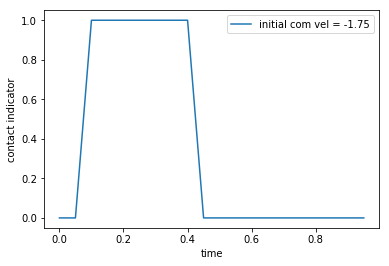

In [12]:
# Default Problem
dist_to_wall = dict()
dist_to_wall['left'] = -0.5
dist_to_wall['right'] = 0.5

robot = CSU.make_box_atlas()

env = CSU.make_environment(dist_to_wall=dist_to_wall)
initial_state = CSU.make_default_initial_state(robot)
desired_state = CSU.make_default_desired_state(robot)

initial_state.vcom[0] = -1.75
initial_state.contact_indicator = np.array([0,1,1,0], dtype=int)


num_time_steps = 20
dt = 0.05

constrained_limbs = dict()
constrained_limbs["right_leg"] = 1 # persistent contact
constrained_limbs["left_leg"] = 1 # persistent contact
# constrained_limbs["right_arm"] = 0 # no contact

contact_assignments = CSU.make_contact_assignment(dt, num_time_steps,
                                              constrained_limbs=constrained_limbs)



params = CSU.get_default_optimization_parameters()

# test out the lambda contact formulation
# this enumerates all the potential contact mode sequences
options = dict()
options["use_lambda_contact_formulation"] = False


opt = BoxAtlasContactStabilization(robot, initial_state, env, desired_state,
                             num_time_steps=num_time_steps,
                             dt=dt,
                             params=params,
                             contact_assignments=contact_assignments,
                                  options=options)

# opt.add_limb_running_costs(desired_state)

# set the MIPGap option for the Gurobi solver
# MIPGap = 1e-4 # gap between current incumbent and largest lower bound
# opt.prog.SetSolverOption(mathematicalprogram.SolverType.kGurobi, "MIPGap", MIPGap)




solnData = opt.solve()
box.planPlayback(vis, solnData, slider=True)
print("solution took = ", solnData.solve_time)
CSU.plot_contact_indicator(solnData)

In [ ]:
# WARNING: This could take a while to run

# Solve a sequence of problems for different initial velocities
vcom_x_list = np.arange(-1.0,-4.01, -0.25)
# vcom_x_list = [-2.0, -1.0]
solnDataList = []
for vcom_x in vcom_x_list:
    initial_state = makeDefaultInitialState()
    initial_state.vcom = np.array([vcom_x, 0])
    
    opt = BoxAtlasContactStabilization(initial_state, env, params=params)
    add_feet_always_in_contact_constraints(opt)
    solnDataList.append(solveContactStabilization(opt=opt))
    

    
# for each of those solve along their resulting trajectories as well
# solnDataAlongTrajectory = []
# for solnData in solnDataList:
#     solnDataAlongTrajectory.append(solveAlongTrajectory(solnData))


In [ ]:
# try some simple plotting


qcom_x = []
vcom_x = []
num_timesteps_in_contact = []

for solnDataList in solnDataAlongTrajectory:
    for solnData in solnDataList:
        qcom_x.append(solnData.states(0).qcom[0])
        vcom_x.append(solnData.states(0).vcom[0])
        contact_indicator = getContactIndicatorVariable(solnData, "left_arm")
        num_timesteps_in_contact.append(sum(contact_indicator))
        
        
qcom_x = np.array(qcom_x)
vcom_x = np.array(vcom_x)
num_timesteps_in_contact = np.array(num_timesteps_in_contact)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.scatter(qcom_x, vcom_x, num_timesteps_in_contact, c=num_timesteps_in_contact,
                  cmap=cm.coolwarm, antialiased=False)

# surf = ax.plot_wireframe(qcom_x, vcom_x, num_timesteps_in_contact,
#                   cmap=cm.coolwarm, antialiased=False)
ax.set_xlabel("com x position")
ax.set_ylabel("com x velocity")

In [ ]:
slider = widgets.IntSlider(min=0,max=len(solnDataList)-1,step=1,value=0)
interact(plotContactIndicatorWidget, idx=slider, solnDataList=fixed(solnDataList))

# plot the trajectory of the com for each initial condition specified above
for solnData in solnDataList:
    states = solnData.states
    qcom_array = arrayFromStateTrajectory(states,'qcom')
    vcom_array = arrayFromStateTrajectory(states, 'vcom')
    plt.plot(qcom_array[:,0], vcom_array[:,0])
    
plt.xlabel('com x position')
plt.ylabel('com x velocity')
plt.show()



In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

for solnData in solnDataList:
    contact_indicator_left_arm = getContactIndicatorVariable(solnData, contact_name="left_arm")
    ts = solnData.ts
    vcom_x = solnData.states(0).vcom[0]
    label = 'initial com vel = ' + str(vcom_x)
    ax.plot(ts[:-1], contact_indicator_left_arm, label=label, alpha=1.0)
#     ax.legend(loc='best')
#     plt.xlabel('time')
#     plt.ylabel('contact indicator')
#     plt.show()
    fig.show()
    time.sleep(0.25)
    fig.clf()

In [ ]:
solnData = solnDataList[6]
vcom_x = solnData.states(0).vcom[0]
box.planPlayback(vis, solnData, slider=True)
print("com initial x velocity = ", vcom_x)

In [ ]:
a = [1,2,3]
sum(a)

In [ ]:
# Solve an MIQP for each state along the initial solution
initial_state = makeDefaultInitialState()
initial_state.vcom = np.array([-4.0, 0.])
opt = BoxAtlasContactStabilization(initial_state, env, params=params)
solnData = solveContactStabilization(opt=opt)

solnDataAlongTrajectory = []
solnDataAlongTrajectory.append(solnData)

box.planPlayback(vis, solnData, slider=True)


for t in solnData.ts[:-1]:
    print("solving program for t = ", t)
    boxAtlasState = solnData.states(t)
    solnDataAlongTrajectory.append(solveContactStabilization(initial_state=boxAtlasState))

In [ ]:
# plot switching sequence as we move along trajectory

ts_orig = solnData.ts
def customPlotting(idx):
    solnData = solnDataAlongTrajectory[idx]
    t = ts_orig[idx]
    contact_indicator_left_arm = getContactIndicatorVariable(solnData, contact_name="left_arm")
    ts = solnData.ts
    vcom_x = solnData.states(0).vcom[0]
    label = 'start time  = ' + str(t)
    plt.plot(t + ts[:-1], contact_indicator_left_arm, label=label, alpha=1.0)
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.ylabel('contact indicator')
    plt.show()
    
slider = widgets.IntSlider(min=0,max=len(solnDataAlongTrajectory)-1,step=1,value=0)
interact(customPlotting, idx=slider)

In [ ]:
idx = 5
box.planPlayback(vis, solnDataAlongTrajectory[idx], slider=True)

In [ ]:
import utils.polynomial

In [ ]:
test = utils.polynomial.Polynomial([1])

In [ ]:
test.evaluate(10)